

1.   Import Package
2.   Data Cleaning and processing
3.   Word Embedding (Word2Vec)
2.   Implemented LSTM
2.   Implement BiLSTM


In [ ]:
#install libraries
!pip install bnlp
!pip install bnlp_toolkit
!pip install --upgrade bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for bnlp: filename=bnlp-0.8-py3-none-any.whl size=32825 sha256=91d1090db0116e964fe59e2433640ac56c8715ed2fc6f08dde3989769bde6957
  Stored in directory: /root/.cache/pip/wheels/64/c7/7e/272284eb8c800fbb5306bdf7904ae9f99a64812fc615f471b2
Successfully built bnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 61.0 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171048 sha256=db5513ebb436a6c06a7d2b2ebf1b57b0f16e84f1

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#import libraries
import numpy as np
import pandas as pd
import random
import re, string
import seaborn as sns
import matplotlib.pyplot as plt

from string import punctuation
from bnlp import BasicTokenizer
from bnlp import NLTKTokenizer
from bnlp import SentencepieceTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits
from bnlp.corpus.util import remove_stopwords
from bnlp import BengaliWord2Vec

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


#PyTorch LSTM
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

import gensim
from gensim.models import Word2Vec, FastText

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

<ipython-input-3-4edda087e305>:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

## Define Performance Metrics & Confusion Matrix 

In [ ]:
# Calculate performance metrics
def perf_matrix(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')

  print('Accuracy:', accuracy)
  print('Precision:', precision)
  print('Recall:', recall)
  print('F1 Score:', f1)

# Plot confusion matrix
def conf_matrix(y_test, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(4,4))
    ax=sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Greens", fmt='g', cbar=True, annot_kws={"size":20})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd drive/MyDrive/Colab Notebooks/Thesis Project/

/content/drive/MyDrive/Colab Notebooks/Thesis Project


In [ ]:
!ls


'0. Depression Analysis Dataset.xlsx'
'1. Depression Analysis Dataset Cleaned v1.xlsx'
'1. Depression Analysis Dataset Cleaned v2.xlsx'
'1. Depression Analysis Dataset Cleaned v3.xlsx'
'1. Depression Analysis v1.ipynb'
'2.1 Depression Analysis v2 (Previous code).ipynb'
'2.2 Depression Analysis v2.ipynb'
'2.3 Depression Analysis v2 modified.ipynb'
'3.1 Depression_Analysis_v3.ipynb'
'3.2 Depression_Analysis_v3 (FastText).ipynb'
'4. Depression_Analysis (Hyperparameter Tuning).ipynb'
 corpus.txt
 model_GRU.pth
 state_dict.pt


In [ ]:
df = pd.read_excel('0. Depression Analysis Dataset.xlsx')

print(df.info())
print("")
print(df.label.value_counts())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18390 entries, 0 to 18389
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         18390 non-null  object
 1   label        18390 non-null  object
 2   word_length  18390 non-null  int64 
 3   text_length  18390 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 574.8+ KB
None

Non Depressive    9402
Depressive        8988
Name: label, dtype: int64


,text,label,word_length,text_length
0,"আমি কয়েকদিন ধরে অনলাইনে পোস্ট করার কথা ভাবছি,...",Depressive,2088,12273
1,আমি আশা করি না যে কেউ এই বিশৃঙ্খল জগাখিচুড়ি প...,Depressive,2173,12230
2,আমি কি কখনও লক্ষ্য করা হবে? আমার জীবনের কি কোন...,Depressive,2229,12117
3,আমি সমর্থন বা উত্সাহ প্রয়োজন. আমি (29এম ) সত্...,Depressive,1912,11271
4,এটি ভেন্ট। আমি (29M) সত্যিই জানি না যে আমি এখ...,Depressive,1905,11216
5,আমি তুরস্কে বসবাসকারী একজন। আমার বয়স সম্ভবত আ...,Depressive,1976,10966
6,আমি ক্রমাগত নিজেকে পুনরাবৃত্তি করি যে আমাকে কখ...,Depressive,1765,10314
7,এটি কিছুক্ষণ আগে ঘটেছিল তবে এটি এখনও আমাকে বির...,Depressive,1753,9970
8,আমি 27 বছর বয়সী এবং আমি প্রায় 24/25 বছর বয়স...,Depressive,1705,9879
9,আমার পুরো জীবন গত কয়েক মাসে স্বতঃস্ফূর্তভাবে ...,Depressive,1649,9407


# Data Cleaning

In [ ]:
# Drop rows with any missing values
df = df.dropna(subset=['text', 'label'])
# drop rows that have identical values in all columns
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18387 entries, 0 to 18389
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         18387 non-null  object
 1   label        18387 non-null  object
 2   word_length  18387 non-null  int64 
 3   text_length  18387 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 718.2+ KB


In [ ]:
# Bengali stopwords, punctuation, letters, digits
print(stopwords)
print(punctuations)
print(letters)
print(digits)

['অতএব', 'অথচ', 'অথবা', 'অনুযায়ী', 'অনেক', 'অনেকে', 'অনেকেই', 'অন্তত', 'অন্য', 'অবধি', 'অবশ্য', 'অর্থাত', 'আই', 'আগামী', 'আগে', 'আগেই', 'আছে', 'আজ', 'আদ্যভাগে', 'আপনার', 'আপনি', 'আবার', 'আমরা', 'আমাকে', 'আমাদের', 'আমার', 'আমি', 'আর', 'আরও', 'ই', 'ইত্যাদি', 'ইহা', 'উচিত', 'উত্তর', 'উনি', 'উপর', 'উপরে', 'এ', 'এঁদের', 'এঁরা', 'এই', 'একই', 'একটি', 'একবার', 'একে', 'এক্', 'এখন', 'এখনও', 'এখানে', 'এখানেই', 'এটা', 'এটাই', 'এটি', 'এত', 'এতটাই', 'এতে', 'এদের', 'এব', 'এবং', 'এবার', 'এমন', 'এমনকী', 'এমনি', 'এর', 'এরা', 'এল', 'এস', 'এসে', 'ঐ', 'ও', 'ওঁদের', 'ওঁর', 'ওঁরা', 'ওই', 'ওকে', 'ওখানে', 'ওদের', 'ওর', 'ওরা', 'কখনও', 'কত', 'কবে', 'কমনে', 'কয়েক', 'কয়েকটি', 'করছে', 'করছেন', 'করতে', 'করবে', 'করবেন', 'করলে', 'করলেন', 'করা', 'করাই', 'করায়', 'করার', 'করি', 'করিতে', 'করিয়া', 'করিয়ে', 'করে', 'করেই', 'করেছিলেন', 'করেছে', 'করেছেন', 'করেন', 'কাউকে', 'কাছ', 'কাছে', 'কাজ', 'কাজে', 'কারও', 'কারণ', 'কি', 'কিংবা', 'কিছু', 'কিছুই', 'কিন্তু', 'কী', 'কে', 'কেউ', 'কেউই', 'কেখা', 'কেন', 'কোটি', 'কোন', 'কোনও'

In [ ]:
# Define the list of Bangla punctuations, digits                                                                                                         
deleted_list = list(punctuation) + list(digits) + ['|', '‘', '’','।','।', '...', '``', '/''','ã','¢','ƒ','¡','ª','‚','«','ç','§','¯','®','å','â','œ','›','½','æ','†','€','α','ž','β','γ','â€','ð','Ÿ','˜','','¼','¦','³','°','¥','¿','¡','„','¶','´','‡','·','»','','››']
print(deleted_list)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯', '|', '‘', '’', '।', '।', '...', '``', '/', 'ã', '¢', 'ƒ', '¡', 'ª', '‚', '«', 'ç', '§', '¯', '®', 'å', 'â', 'œ', '›', '½', 'æ', '†', '€', 'α', 'ž', 'β', 'γ', 'â€', 'ð', 'Ÿ', '˜', '\x90', '¼', '¦', '³', '°', '¥', '¿', '¡', '„', '¶', '´', '‡', '·', '»', '', '››']


In [ ]:
# Initialize the tokenizer
tokenizer = word_tokenize

# Define a function to preprocess the text data
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub('<[^>]*>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    #remove \n and \r and lowercase
    text = text.replace('\r', '').replace('\n', ' ').lower() 
    #remove links and mentions
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) 
    # Remove english characters and numbers
    text = re.sub(r'[a-zA-Z0-9]+', '', text)
    # Remove irrelevant characters
    text = re.sub(r'[Α-Ωα-ω]+', '', text)

    # text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)

    # Tokenize the text data
    tokens = tokenizer(text)
    # Remove stopwords and punctuations
    tokens = [w.lower() for w in tokens if not w.lower() in stopwords and not w in deleted_list and not w in punctuation and not w.isnumeric() and not w.isalpha()]
    # Join the tokens back to form a string
    processed = ' '.join(tokens)
    return processed

texts_new = []
for t in df.text:
    texts_new.append(preprocess_text(t))

df['text_clean'] = texts_new


In [ ]:
print(df.info())
print("")
print(df.label.value_counts())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18387 entries, 0 to 18389
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         18387 non-null  object
 1   label        18387 non-null  object
 2   word_length  18387 non-null  int64 
 3   text_length  18387 non-null  int64 
 4   text_clean   18387 non-null  object
dtypes: int64(2), object(3)
memory usage: 861.9+ KB
None

Non Depressive    9400
Depressive        8987
Name: label, dtype: int64


,text,label,word_length,text_length,text_clean
0,"আমি কয়েকদিন ধরে অনলাইনে পোস্ট করার কথা ভাবছি,...",Depressive,2088,12273,কয়েকদিন অনলাইনে পোস্ট কথা ভাবছি ভাবছি সমাধান ...
1,আমি আশা করি না যে কেউ এই বিশৃঙ্খল জগাখিচুড়ি প...,Depressive,2173,12230,আশা বিশৃঙ্খল জগাখিচুড়ি পড়বে৷ মুহূর্তে জীবন ক...
2,আমি কি কখনও লক্ষ্য করা হবে? আমার জীবনের কি কোন...,Depressive,2229,12117,লক্ষ্য জীবনের মূল্য সারাদিন কাটাই দুঃখ বেদনায়...
3,আমি সমর্থন বা উত্সাহ প্রয়োজন. আমি (29এম ) সত্...,Depressive,1912,11271,সমর্থন উত্সাহ প্রয়োজন সত্যিই জানি খুঁজছি মস্ত...
4,এটি ভেন্ট। আমি (29M) সত্যিই জানি না যে আমি এখ...,Depressive,1905,11216,ভেন্ট। সত্যিই জানি খুঁজছি মস্তিষ্ককে সক্রিয়ভা...
5,আমি তুরস্কে বসবাসকারী একজন। আমার বয়স সম্ভবত আ...,Depressive,1976,10966,তুরস্কে বসবাসকারী একজন। বয়স সম্ভবত কম। পোস্ট ...
6,আমি ক্রমাগত নিজেকে পুনরাবৃত্তি করি যে আমাকে কখ...,Depressive,1765,10314,ক্রমাগত নিজেকে পুনরাবৃত্তি লড়াই সুযোগ হয়নি। ...
7,এটি কিছুক্ষণ আগে ঘটেছিল তবে এটি এখনও আমাকে বির...,Depressive,1753,9970,কিছুক্ষণ ঘটেছিল বিরক্ত সাহায্য কথা নোংরা করেছে...
8,আমি 27 বছর বয়সী এবং আমি প্রায় 24/25 বছর বয়স...,Depressive,1705,9879,বয়সী বয়স বিষণ্নতায় গভীরভাবে বেড়ে উঠেছি। কঠ...
9,আমার পুরো জীবন গত কয়েক মাসে স্বতঃস্ফূর্তভাবে ...,Depressive,1649,9407,পুরো জীবন মাসে স্বতঃস্ফূর্তভাবে জ্বলে উঠেছে। ব...


In [ ]:
df['label'] = df['label'].replace({'Depressive': 1, 'Non Depressive': 0})

df['length_text'] = df['text'].apply(len)
df['length_text_clean'] = df['text_clean'].apply(len)

# Sort the dataframe by the 'length' column in descending order
df = df.sort_values(by='length_text_clean', ascending=False)
df

,text,label,word_length,text_length,text_clean,length_text,length_text_clean
0,"আমি কয়েকদিন ধরে অনলাইনে পোস্ট করার কথা ভাবছি,...",1,2088,12273,কয়েকদিন অনলাইনে পোস্ট কথা ভাবছি ভাবছি সমাধান ...,12273,7421
1,আমি আশা করি না যে কেউ এই বিশৃঙ্খল জগাখিচুড়ি প...,1,2173,12230,আশা বিশৃঙ্খল জগাখিচুড়ি পড়বে৷ মুহূর্তে জীবন ক...,12230,6853
3,আমি সমর্থন বা উত্সাহ প্রয়োজন. আমি (29এম ) সত্...,1,1912,11271,সমর্থন উত্সাহ প্রয়োজন সত্যিই জানি খুঁজছি মস্ত...,11271,6549
4,এটি ভেন্ট। আমি (29M) সত্যিই জানি না যে আমি এখ...,1,1905,11216,ভেন্ট। সত্যিই জানি খুঁজছি মস্তিষ্ককে সক্রিয়ভা...,11216,6478
2,আমি কি কখনও লক্ষ্য করা হবে? আমার জীবনের কি কোন...,1,2229,12117,লক্ষ্য জীবনের মূল্য সারাদিন কাটাই দুঃখ বেদনায়...,12117,6114
...,...,...,...,...,...,...,...
17303,Í Í Í Í Í Í Í Í Í Í Í Í Í Í Í Í Í ÍÍÍÍ Í Í Í Í...,0,140,299,,299,0
14369,পগ পগ পগ পগ পগ পগ পগ পগ পগ পগ পগ পগ পগ পগ পগ প...,0,175,524,,524,0
7173,â â â â â â â â â â â â â â_x_8d_ â_x_8d_ â_x_...,0,302,1026,,1026,0
4117,"Longboi"" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""...",0,748,1517,,1517,0


In [ ]:
# Filter the rows whose length is less than 30
filtered_df_min = df[df['length_text_clean'] < 30]

# Print the filtered data
print(len(filtered_df_min))
filtered_df_min.head(10)

42


,text,label,word_length,text_length,text_clean,length_text,length_text_clean
3589,ভার্চুয়াল বুদ্বুদ র‍্যাপ কারণ irl এখন পপ করে ...,0,400,1614,ভার্চুয়াল বুদ্বুদ র‍্যাপ শুভ,1614,29
18262,"হ্যালো, সেখানে, ââ ââ ââ ââ ââ ââ "" "" "" আমি...",0,67,228,হ্যালো এইমাত্র পাশ যাচ্ছি না।,228,29
16568,এসে ভাবি (৩২ খণ্ড) ইভ ইভ ইভ ইভ ইভ ইভ ইভ ইভ ইভ ...,0,69,360,ভাবি খণ্ড প্রসঙ্গ জীবনী পার্ট,360,29
4467,আমি এই চাবি খুঁজে পেয়েছি. আশ্চর্য এটা কি করে?...,0,683,1442,চাবি খুঁজে পেয়েছি আশ্চর্য ‰,1442,28
6771,"এটি স্বাস্থ্যকর সুস্থ "" "" „"" "" „"" "" „"" "" „"" ""...",0,429,1061,স্বাস্থ্যকর সুস্থ ‰ £ ‰ “ “,1079,27
6573,"আরে আপনি, হ্যাঁ আপনি reddit এর মাধ্যমে স্ক্রোল...",0,430,1077,আরে হ্যাঁ স্ক্রোল “ জিতেছেন,1077,27
18353,কেউ কি নিজের মধ্য দিয়ে যেতে পারে কারণ আমি মনে...,1,39,182,মধ্য অনুভব ঘৃণা কাজটি কষ্ট,182,26
8460,"ভাই 2020এর অভিনয় কেমন "" "" ¦¦¡""...",0,333,833,ভাই অভিনয় কেমন ¦¦¡ ‰ ¡†,833,24
504,না এটা ঠিক হতে পারে না? সর্বোপরি আমি ঠিকই পার ...,0,364,3050,সর্বোপরি ঠিকই পার করেছি,3050,23
7259,"চুংগুস "" ""...",0,431,1017,চুংগুস ‰ ‰ ” ¡… ” ¡• ‰,1023,22


In [ ]:
filtered_df_max = df[df['length_text_clean'] > 6000]

# Print the filtered data
print(len(filtered_df_max))
filtered_df_max.head(10)

6


,text,label,word_length,text_length,text_clean,length_text,length_text_clean
0,"আমি কয়েকদিন ধরে অনলাইনে পোস্ট করার কথা ভাবছি,...",1,2088,12273,কয়েকদিন অনলাইনে পোস্ট কথা ভাবছি ভাবছি সমাধান ...,12273,7421
1,আমি আশা করি না যে কেউ এই বিশৃঙ্খল জগাখিচুড়ি প...,1,2173,12230,আশা বিশৃঙ্খল জগাখিচুড়ি পড়বে৷ মুহূর্তে জীবন ক...,12230,6853
3,আমি সমর্থন বা উত্সাহ প্রয়োজন. আমি (29এম ) সত্...,1,1912,11271,সমর্থন উত্সাহ প্রয়োজন সত্যিই জানি খুঁজছি মস্ত...,11271,6549
4,এটি ভেন্ট। আমি (29M) সত্যিই জানি না যে আমি এখ...,1,1905,11216,ভেন্ট। সত্যিই জানি খুঁজছি মস্তিষ্ককে সক্রিয়ভা...,11216,6478
2,আমি কি কখনও লক্ষ্য করা হবে? আমার জীবনের কি কোন...,1,2229,12117,লক্ষ্য জীবনের মূল্য সারাদিন কাটাই দুঃখ বেদনায়...,12117,6114
6,আমি ক্রমাগত নিজেকে পুনরাবৃত্তি করি যে আমাকে কখ...,1,1765,10314,ক্রমাগত নিজেকে পুনরাবৃত্তি লড়াই সুযোগ হয়নি। ...,10314,6004


In [ ]:
# Filter rows based on length of text_clean column
df = df[(df['length_text_clean'] <= 6000) & (df['length_text_clean'] >= 30)]
print(df.info())
print("")
print(df.label.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18339 entries, 8 to 4650
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               18339 non-null  object
 1   label              18339 non-null  int64 
 2   word_length        18339 non-null  int64 
 3   text_length        18339 non-null  int64 
 4   text_clean         18339 non-null  object
 5   length_text        18339 non-null  int64 
 6   length_text_clean  18339 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.1+ MB
None

0    9364
1    8975
Name: label, dtype: int64


Shortest text length: 30
Longest text length: 5900
Mean 590.7794863405857


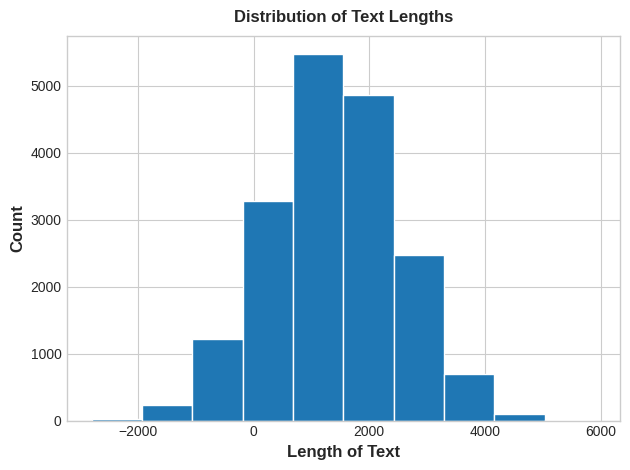

In [ ]:
# calculate minimum and maximum lengths
min_length = df["length_text_clean"].min()
max_length = df["length_text_clean"].max()

print("Shortest text length:", min_length)
print("Longest text length:", max_length)

mean = df['length_text_clean'].mean()
std = df['length_text_clean'].std()
print("Mean", mean)

# Generate a normal distribution with the same mean and standard deviation
normal_distribution = np.random.normal(mean, std, len(df))

# Convert the normal distribution to a range of lengths from min_length to max_length
converted_distribution = np.floor(normal_distribution * max_length / np.max(normal_distribution))

# Plot the data in a histogram
plt.hist(converted_distribution)
plt.xlabel('Length of Text')
plt.ylabel('Count')
plt.title('Distribution of Text Lengths')
plt.show()

In [ ]:
# Replace the 'text' column with 'text_clean' 
df['text'] = df['text_clean']

# Drop the irrelevant columns
df = df.drop(['text_clean','length_text', 'length_text_clean','word_length','text_length'], axis=1)

print(df.info())
print("")
print(df.label.value_counts())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18339 entries, 8 to 4650
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    18339 non-null  object
 1   label   18339 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 429.8+ KB
None

0    9364
1    8975
Name: label, dtype: int64


<ipython-input-19-c51d7c8a9da5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text_clean']


,text,label
8,বয়সী বয়স বিষণ্নতায় গভীরভাবে বেড়ে উঠেছি। কঠ...,1
5,তুরস্কে বসবাসকারী একজন। বয়স সম্ভবত কম। পোস্ট ...,1
7,কিছুক্ষণ ঘটেছিল বিরক্ত সাহায্য কথা নোংরা করেছে...,1
9,পুরো জীবন মাসে স্বতঃস্ফূর্তভাবে জ্বলে উঠেছে। ব...,1
12,শীঘ্রই বয়সী। মুহুর্তে সিডি সামাজিক জীবনে বড় ...,1
10,মানসিক শারীরিকভাবে অসুস্থ ক্লান্ত। পুরো জীবন শ...,1
13,জানতাম সাথে ভুল ছিল। লোক খারাপ জীবন কাটিয়েছে ...,1
18,দয়া সাথে থাকুন অত্যন্ত দীর্ঘ আপনাকে পড়তে উত্...,1
29,অনেটিভ ইংরেজি স্পিকারের অনুসরণ বিরক্তিকর অপ্রত...,1
14,দৈর্ঘ্যের ক্ষমাপ্রার্থী। বোঝানোর বের আলিঙ্গন ব...,1


In [ ]:
# Find the number of samples in label class
class_counts = df['label'].value_counts()

# Determine the majority and minority classes
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

# Calculate the difference between the number of samples in the majority and minority classes
class_diff = class_counts[majority_class] - class_counts[minority_class]

# If the difference is positive, we need to remove samples from the majority class
if class_diff > 0:
    # Get the indices of the majority class samples
    majority_indices = df[df['label'] == majority_class].index
    
    # Randomly sample from the majority class indices to remove
    remove_indices = np.random.choice(majority_indices, size=class_diff, replace=False)
    
    # Drop the samples with the selected indices
    df = df.drop(remove_indices)
    
# If the difference is negative, we need to remove samples from the minority class
elif class_diff < 0:
    # Get the indices of the minority class samples
    minority_indices = df[df['label'] == minority_class].index
    
    # Randomly sample from the minority class indices to remove
    remove_indices = np.random.choice(minority_indices, size=-class_diff, replace=False)
    
    # Drop the samples with the selected indices
    df = df.drop(remove_indices)

print(df.info())
print("")
print(df.label.value_counts())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17950 entries, 8 to 4650
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    17950 non-null  object
 1   label   17950 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 420.7+ KB
None

1    8975
0    8975
Name: label, dtype: int64


,text,label
8,বয়সী বয়স বিষণ্নতায় গভীরভাবে বেড়ে উঠেছি। কঠ...,1
5,তুরস্কে বসবাসকারী একজন। বয়স সম্ভবত কম। পোস্ট ...,1
7,কিছুক্ষণ ঘটেছিল বিরক্ত সাহায্য কথা নোংরা করেছে...,1
9,পুরো জীবন মাসে স্বতঃস্ফূর্তভাবে জ্বলে উঠেছে। ব...,1
12,শীঘ্রই বয়সী। মুহুর্তে সিডি সামাজিক জীবনে বড় ...,1
10,মানসিক শারীরিকভাবে অসুস্থ ক্লান্ত। পুরো জীবন শ...,1
13,জানতাম সাথে ভুল ছিল। লোক খারাপ জীবন কাটিয়েছে ...,1
18,দয়া সাথে থাকুন অত্যন্ত দীর্ঘ আপনাকে পড়তে উত্...,1
29,অনেটিভ ইংরেজি স্পিকারের অনুসরণ বিরক্তিকর অপ্রত...,1
14,দৈর্ঘ্যের ক্ষমাপ্রার্থী। বোঝানোর বের আলিঙ্গন ব...,1


In [ ]:
# save the updated DataFrame to a new excel file
df.to_excel('1. Depression Analysis Dataset Cleaned v2.xlsx', index=False)

In [ ]:
df = pd.read_excel('1. Depression Analysis Dataset Cleaned v2.xlsx')

print(df.info())
print("")
print(df.label.value_counts())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17950 entries, 0 to 17949
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    17950 non-null  object
 1   label   17950 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 280.6+ KB
None

1    8975
0    8975
Name: label, dtype: int64


,text,label
0,বয়সী বয়স বিষণ্নতায় গভীরভাবে বেড়ে উঠেছি। কঠ...,1
1,তুরস্কে বসবাসকারী একজন। বয়স সম্ভবত কম। পোস্ট ...,1
2,কিছুক্ষণ ঘটেছিল বিরক্ত সাহায্য কথা নোংরা করেছে...,1
3,পুরো জীবন মাসে স্বতঃস্ফূর্তভাবে জ্বলে উঠেছে। ব...,1
4,শীঘ্রই বয়সী। মুহুর্তে সিডি সামাজিক জীবনে বড় ...,1
5,মানসিক শারীরিকভাবে অসুস্থ ক্লান্ত। পুরো জীবন শ...,1
6,জানতাম সাথে ভুল ছিল। লোক খারাপ জীবন কাটিয়েছে ...,1
7,দয়া সাথে থাকুন অত্যন্ত দীর্ঘ আপনাকে পড়তে উত্...,1
8,অনেটিভ ইংরেজি স্পিকারের অনুসরণ বিরক্তিকর অপ্রত...,1
9,দৈর্ঘ্যের ক্ষমাপ্রার্থী। বোঝানোর বের আলিঙ্গন ব...,1


# Train Test Split

In [ ]:
# Load data
df = pd.read_excel('1. Depression Analysis Dataset Cleaned v2.xlsx')

In [ ]:
# shuffle the rows
df = df.sample(frac=1)
df.head(10)

,text,label
2238,ধন্যবাদ বাবা সত্যিকার অর্থে উৎসাহজনক কথাগুলো প...,1
243,নস্টালজিয়া অনুগ্রহ অনুভূতিটি পড়ুন। একটা চিন্...,0
1689,আসলেই অপরকে ভালবাসে পরিবারের লোকদের ঈর্ষান্বিত...,1
6080,সত্যিই দুর্দান্ত আক্ষরিক অর্থে একা থাকতে আশা ম...,1
2018,সহপাঠীরা সত্যিই যত্ন করছিলাম জটিল সার্কিট ব্যা...,0
4174,মানসিক অসুস্থতা আত্মহত্যার চিন্তাভাবনা কিছুর দ...,1
13966,সন্তান তৈরি অর্থ সম্মানের যোগ্য ট্রান্স হওয়াক...,0
7254,মারা যেতাম। তৈরি পারতাম না। সবে গাইতে পারতাম। ...,1
8297,গেমের সুপারিশ পেয়েছি প্রিয় গেমস আন্ডারটেল ডে...,0
5984,সবসময় ধরনের উচ্চ মান অধিষ্ঠিত জিএফ প্রতারণা শ...,1


In [ ]:
X = df['text']
y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 6462],
       [   1, 6462]])

# Naive Bayes baseline model

In [ ]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [ ]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [ ]:
nb_clf = MultinomialNB()

In [ ]:
nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [ ]:
nb_pred = nb_clf.predict(X_test_tf)

In [ ]:
label = ['0', '1']

In [ ]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=label))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.87      0.76      0.81      1795
           1       0.79      0.89      0.84      1795

    accuracy                           0.83      3590
   macro avg       0.83      0.83      0.82      3590
weighted avg       0.83      0.83      0.82      3590



Accuracy: 0.8253481894150417
Precision: 0.8302642920873682
Recall: 0.8253481894150417
F1 Score: 0.8246958229969316


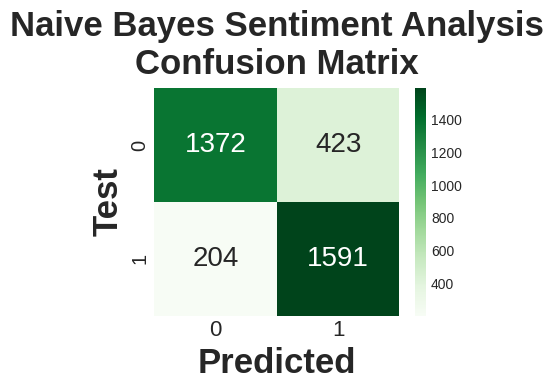

In [ ]:
perf_matrix(y_test, nb_pred)
conf_matrix(y_test, nb_pred, 'Naive Bayes Sentiment Analysis\nConfusion Matrix', label)

# Data preprocessing for LSTM

In [ ]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [ ]:
max_len = 5000

In [ ]:
vocabulary, tokenized_column = Tokenize(df["text"], max_len)

In [ ]:
vocabulary[:20]

[('সাথে', 24522),
 ('না।', 18631),
 ('চাই', 14293),
 ('কথা', 11425),
 ('জানি', 11052),
 ('করেছি', 10807),
 ('সত্যিই', 9677),
 ('নিজেকে', 8401),
 ('করছি', 8398),
 ('সম্পর্কে', 8236),
 ('সময়', 8117),
 ('খারাপ', 7958),
 ('ভাল', 7829),
 ('অনুভব', 7206),
 ('শেষ', 6788),
 ('সাহায্য', 6154),
 ('জীবন', 6017),
 ('বোধ', 5876),
 ('বন্ধু', 5754),
 ('ছিলাম', 5544)]

In [ ]:
len(vocabulary)

63366

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2488 (\N{BENGALI LETTER SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2494 (\N{BENGALI VOWEL SIGN AA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2469 (\N{BENGALI LETTER THA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2503 (\N{BENGALI VOWEL SIGN E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/

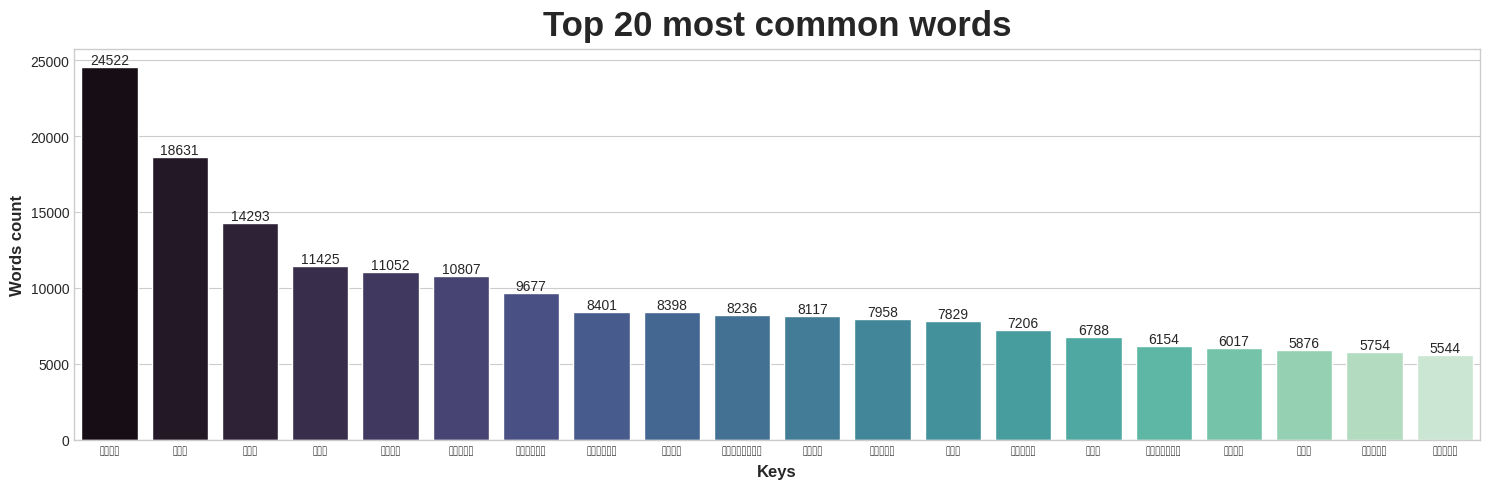

In [ ]:

"""
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

plt.figure(figsize=(15, 5))
# create barplot
ax = sns.barplot(x=keys, y=values, palette='mako')

# set labels
ax.set(xlabel='Keys', ylabel='Values')

plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()
"""

In [ ]:
tokenized_column[3:6]

array([[    0,     0,     0, ...,   645,   124,  1405],
       [    0,     0,     0, ..., 18998, 18999,   381],
       [    0,     0,     0, ...,   113,   884,    56]])

In [ ]:
df["text"].iloc[10]

'আক্ষরিক অর্থে এটাকে ঘৃণা ব্রুহ বোকা ফাগলি মোটা কুৎসিত গাধা দুশ্চরিত্রা মা আক্ষরিক অর্থে শীতের মাঝখানে হিমায়িত গাধা ঝরনা বাধ্য করেনি তর্কের পড়েছিলাম সংরক্ষণ বলেছিলাম আক্ষরিকভাবে শেষ করেছি ফ্যাটাস আক্ষরিকভাবে স্নান অপেক্ষা পারেনি ইতিমধ্যেই আজকে গ্রহণ করেনি৷ কুৎসিত মোটা গাধা কদর্য খসখসে কুত্তার আক্ষরিক অর্থে ঘন্টা সময় লাগে ঝরনাটি সম্পূর্ণরূপে জেনেও সাহস আগামীকাল চলেছে বেরিয়ে এসেছি করেছিলাম কেমন নোংরা ঘামে ঘুমানোর কথা তর্ক করেছি আক্ষরিক অর্থে কুত্তাকে বলেছিলাম জানত স্নান গৃহস্থালির স্নান প্রয়োজন মুখের দুজনেই অন্যকে পছন্দ বোকা দুশ্চরিত্রা ফোন ফোনের বিল পরিশোধ কুত্তা বাবা বিল হস্তান্তর এমনকি গন্ধযুক্ত কাকা গন্ধযুক্ত হাত স্পর্শ আক্ষরিক অর্থে বোকা দুশ্চরিত্রা কথা বলছে কীভাবে মা চাননি সম্মান দেখাতে আপনাকে দেখাব চিকেন মোরগ আলগা গাধা ঘাড় চিবুক চর্বি স্থির কুশ্রী দুশ্চরিত্রা পেতে যৌনসঙ্গম শ্রদ্ধা যাই আক্ষরিক হিমায়িত ঝরনা বেরিয়ে এলাম বাজে হলুদ আঁকাবাঁকা দাঁতের সাথে মুখে কুৎসিত গাধা হাসি ছিল। রান্ট ওভার'

In [ ]:
tokenized_column[10]

array([   0,    0,    0, ...,   47, 4148, 4282])

# Word Embedding by Word2Vec

In [ ]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [ ]:
EMBEDDING_DIM = 200

In [ ]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [ ]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 63367


In [ ]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding
VOCAB_SIZE

63367

In [ ]:
#define empty embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    
#fill the embedding matrix with the pre trained values from word2vec
#    corresponding to word (string), token (number associated to the word)
for word, token in vocabulary:
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (63367, 200)


## Train - Validation - Test split

In [ ]:
df.head(10)

,text,label
2238,ধন্যবাদ বাবা সত্যিকার অর্থে উৎসাহজনক কথাগুলো প...,1
243,নস্টালজিয়া অনুগ্রহ অনুভূতিটি পড়ুন। একটা চিন্...,0
1689,আসলেই অপরকে ভালবাসে পরিবারের লোকদের ঈর্ষান্বিত...,1
6080,সত্যিই দুর্দান্ত আক্ষরিক অর্থে একা থাকতে আশা ম...,1
2018,সহপাঠীরা সত্যিই যত্ন করছিলাম জটিল সার্কিট ব্যা...,0
4174,মানসিক অসুস্থতা আত্মহত্যার চিন্তাভাবনা কিছুর দ...,1
13966,সন্তান তৈরি অর্থ সম্মানের যোগ্য ট্রান্স হওয়াক...,0
7254,মারা যেতাম। তৈরি পারতাম না। সবে গাইতে পারতাম। ...,1
8297,গেমের সুপারিশ পেয়েছি প্রিয় গেমস আন্ডারটেল ডে...,0
5984,সবসময় ধরনের উচ্চ মান অধিষ্ঠিত জিএফ প্রতারণা শ...,1


In [ ]:
X = tokenized_column
y = df['label'].values
y

array([1, 0, 1, ..., 1, 1, 0])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 6462],
       [   1, 6462]])

# PyTorch datasets and dataloaders

In [ ]:
BATCH_SIZE = 8
EPOCHS = 5 #Number of training epoch
LR = 0.003 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
WEIGHT_DECAY = 0.001
LSTM_LAYERS = 1 #Number of stacked LSTM layers
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)

NUM_CLASSES = 2 #We are dealing with a multiclass classification of 2 classes
BIDIRECTIONAL = False #Boolean value to choose if to use a bidirectional LSTM or not

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [ ]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

## PyTorch LSTM modeling

In [ ]:
class LSTM_Sentiment_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(LSTM_Sentiment_Classifier,self).__init__()
        
        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)
        return hidden

In [ ]:
model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
model = model.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
model.embedding.weight.requires_grad=True

print(model)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM_Sentiment_Classifier(
  (embedding): Embedding(63367, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=100, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = WEIGHT_DECAY)

### LSTM Training loop 

In [ ]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 88.966480).  Saving model ...
	Train_loss : 0.3897 Val_loss : 0.2891
	Train_acc : 82.531% Val_acc : 88.966%
Epoch 2:Validation accuracy did not increase
	Train_loss : 0.1316 Val_loss : 0.3328
	Train_acc : 95.217% Val_acc : 87.081%
Epoch 3:Validation accuracy did not increase
	Train_loss : 0.0457 Val_loss : 0.4842
	Train_acc : 98.622% Val_acc : 85.964%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0177 Val_loss : 0.5677
	Train_acc : 99.458% Val_acc : 85.824%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0086 Val_loss : 0.8127
	Train_acc : 99.768% Val_acc : 83.170%


In [ ]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

### LSTM Testing

In [ ]:
model.eval()
y_pred_list = []
y_test_list = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    test_h = model.init_hidden(labels.size(0))

    output, val_h = model(inputs, test_h)
    y_pred_test = torch.argmax(output, dim=1)
    y_pred_list.extend(y_pred_test.squeeze().tolist())
    y_test_list.extend(labels.squeeze().tolist())

In [ ]:
label = ['0', '1']

In [ ]:
print('Classification Report for LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=label))

In [ ]:
perf_matrix(y_test_list, y_pred_list)
conf_matrix(y_test_list,y_pred_list,'PyTorch LSTM Sentiment Analysis\nConfusion Matrix', label)

## PyTorch BiLSTM modeling

In [ ]:
NUM_CLASSES = 2 #We are dealing with a multiclass classification of 2 classes
BIDIRECTIONAL = True #Boolean value to choose if to use a bidirectional LSTM or not

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class BiLSTM_Sentiment_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(BiLSTM_Sentiment_Classifier,self).__init__()
        
        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)
        return hidden

In [ ]:
model = BiLSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
model = model.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
model.embedding.weight.requires_grad=True

print(model)

BiLSTM_Sentiment_Classifier(
  (embedding): Embedding(63229, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = WEIGHT_DECAY)

### BiLSTM Training loop 

In [ ]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 87.569832).  Saving model ...
	Train_loss : 0.4785 Val_loss : 0.3019
	Train_acc : 75.797% Val_acc : 87.570%
Epoch 2:Validation accuracy increased (87.569832 --> 89.175978).  Saving model ...
	Train_loss : 0.2225 Val_loss : 0.2726
	Train_acc : 91.718% Val_acc : 89.176%
Epoch 3:Validation accuracy did not increase
	Train_loss : 0.1256 Val_loss : 0.3528
	Train_acc : 95.820% Val_acc : 88.897%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0696 Val_loss : 0.3761
	Train_acc : 97.810% Val_acc : 88.268%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0346 Val_loss : 0.4832
	Train_acc : 98.971% Val_acc : 86.453%


In [ ]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

### BiLSTM Testing

In [ ]:
model.eval()
y_pred_list = []
y_test_list = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    test_h = model.init_hidden(labels.size(0))

    output, val_h = model(inputs, test_h)
    y_pred_test = torch.argmax(output, dim=1)
    y_pred_list.extend(y_pred_test.squeeze().tolist())
    y_test_list.extend(labels.squeeze().tolist())

In [ ]:
label = ['0','1']

In [ ]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=label))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      1792
           1       0.87      0.91      0.89      1792

    accuracy                           0.88      3584
   macro avg       0.88      0.88      0.88      3584
weighted avg       0.88      0.88      0.88      3584



Accuracy: 0.8842075892857143
Precision: 0.8849941788677453
Recall: 0.8842075892857143
F1 Score: 0.8841484145922086


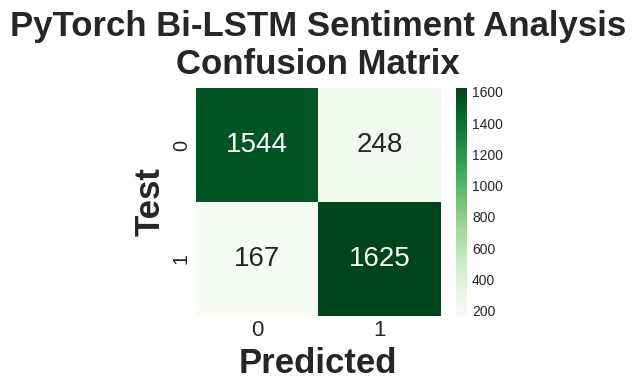

In [ ]:
perf_matrix(y_test_list, y_pred_list)
# conf_matrix(y_test_list,y_pred_list,'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', label)

# Bayesian Optimization